In [1]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import gc

from src.model import model_fit, ensemble_predict, evaluate_n_members
from src.utils import set_seed, portfolio_cumulative_return, prediction_long_short, build_portfolios

In [2]:
# load data
X = pd.read_pickle('data/dataset.pkl')
X.set_index('year_month', inplace=True)

# define columns variables
cols = ['InvestPPEInv', 'ShareIss1Y', 'ShareRepurchase', 'DelCOA', 'dNoa', 'GrLTNOA', 'IntMom', 'LRreversal', 'Mom12m', 'Mom6m', 'MRreversal', 'ResidualMomentum', 'STreversal', 'AM', 'BMdec', 'ChEQ', 'AssetGrowth', 'ChNWC', 'DelEqu', 'NOA', 'Size', 'SP', 'AbnormalAccruals', 'Accruals', 'PctAcc', 'OPLeverage', 'BookLeverage', 'CF', 'cfp', 'DelCOL', 'DelFINL', 'IdioRisk', 'IdioVol3F', 'Leverage', 'Beta', 'BetaFP', 'BidAskSpread', 'DolVol', 'Illiquidity', 'PRC', 'VolMkt', 'VolSD', 'High52', 'MaxRet', 'CashProd', 'GP', 'roaq', 'RoE', 'DelLTI', 'CFNAI', 'P_I', 'EU_H', 'C_H', 'SO_I', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'SENT', 'pdnd', 'ripo', 'nipo', 'cefd', 's', 'ab_capm', 'ab_ff3', 'ab_ff5', 'ex_return']

# firm feature
firm_features = ['InvestPPEInv', 'ShareIss1Y', 'ShareRepurchase', 'DelCOA', 'dNoa', 'GrLTNOA', 'IntMom', 'LRreversal', 'Mom12m', 'Mom6m', 'MRreversal', 'ResidualMomentum', 'STreversal', 'AM', 'BMdec', 'ChEQ', 'AssetGrowth', 'ChNWC', 'DelEqu', 'NOA', 'Size', 'SP', 'AbnormalAccruals', 'Accruals', 'PctAcc', 'OPLeverage', 'BookLeverage', 'CF', 'cfp', 'DelCOL', 'DelFINL', 'IdioRisk', 'IdioVol3F', 'Leverage', 'Beta', 'BetaFP', 'BidAskSpread', 'DolVol', 'Illiquidity', 'PRC', 'VolMkt', 'VolSD', 'High52', 'MaxRet', 'CashProd', 'GP', 'roaq', 'RoE', 'DelLTI']

# macro features
cfnai = ['CFNAI', 'P_I', 'EU_H', 'C_H', 'SO_I']

# sentiment data
sent = ['SENT', 'pdnd', 'ripo', 'nipo', 'cefd', 's']


In [3]:
# split data
from sklearn.model_selection import train_test_split
train, X_test = train_test_split(X, test_size=1/3, shuffle=True, random_state=10)
X_train, X_val = train_test_split(train, test_size=1/2, shuffle=True, random_state=10)

In [4]:
# scale data (standerdized)
# fit scaler to train data, and apply it to validation and test data
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
X_train_scaled = scl.fit_transform(X_train[cols])
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.index = X_train.index
X_train_scaled.columns = cols

X_val_scaled = scl.transform(X_val[cols])
X_val_scaled = pd.DataFrame(X_val_scaled)
X_val_scaled.index = X_val.index
X_val_scaled.columns = cols

X_test_scaled = scl.transform(X_test[cols])
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.index = X_test.index
X_test_scaled.columns = cols

del[train, X_train, X_val, X]
gc.collect()

23

## 1. Predicting only with firm features

In [5]:
# ensemble fit n models
n_models = 10
model_capm_firm, model_ff3_firm, model_ff5_firm, model_ex_firm = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[firm_features], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[firm_features], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[firm_features], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[firm_features], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[firm_features], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[firm_features], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[firm_features], y=X_train_scaled['ex_return'], X_val=X_val_scaled[firm_features], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_firm.append(model_c)
    model_ff3_firm.append(model_3)
    model_ff5_firm.append(model_5)
    model_ex_firm.append(model_e)
clear_output()

In [6]:
# compute r-squared value and predictions in the test dataset
capm_yhats_firm = ensemble_predict(model_capm_firm, X_test_scaled[firm_features])
ff3_yhats_firm = ensemble_predict(model_ff3_firm, X_test_scaled[firm_features])
ff5_yhats_firm = ensemble_predict(model_ff5_firm, X_test_scaled[firm_features])
ex_yhats_firm = ensemble_predict(model_ex_firm, X_test_scaled[firm_features])

from sklearn.metrics import r2_score
capm_r2_firm = r2_score(X_test_scaled['ab_capm'], capm_yhats_firm)
ff3_r2_firm = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_firm)
ff5_r2_firm = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_firm)
ex_r2_firm = r2_score(X_test_scaled['ex_return'], ex_yhats_firm)

clear_output()

### 1.1 Equal weighted portfolios

In [7]:
ew_portfolio_firm = build_portfolios(capm_yhats_firm, ff3_yhats_firm, ff5_yhats_firm, ex_yhats_firm, weight='equal', test_data=X_test)
ew_portfolio_cumulative_firm = portfolio_cumulative_return(data=ew_portfolio_firm)
ew_portfolio_ls_firm = prediction_long_short(data=ew_portfolio_firm)

### 1.2 Value weighted portfolios

In [8]:
vw_portfolio_firm = build_portfolios(capm_yhats_firm, ff3_yhats_firm, ff5_yhats_firm, ex_yhats_firm, weight='value', test_data=X_test)
vw_portfolio_cumulative_firm = portfolio_cumulative_return(data=vw_portfolio_firm)
vw_portfolio_ls_firm = prediction_long_short(data=vw_portfolio_firm)

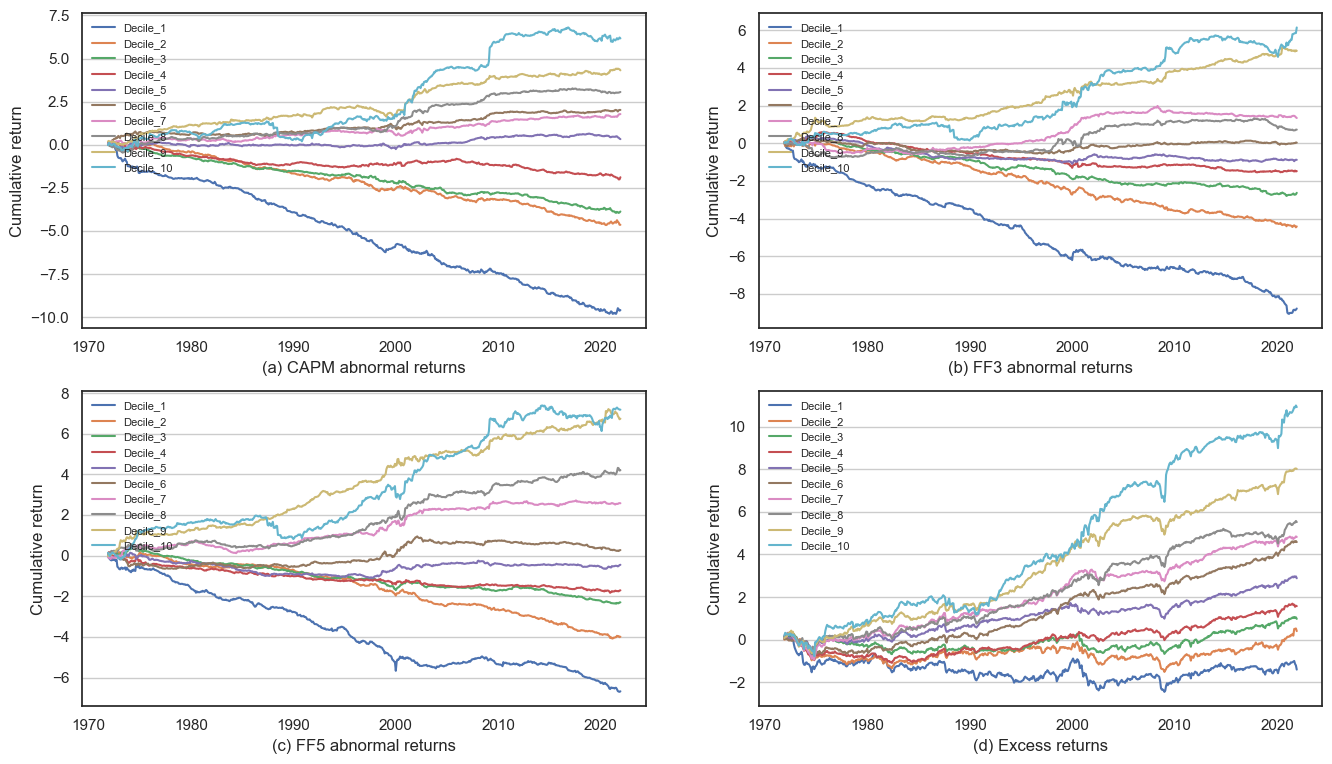

In [9]:
# plot cumulative return of value weighted portfolios
import seaborn as sns
from matplotlib import pyplot
sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(2,2,figsize=(16,9))

sns.lineplot(data=vw_portfolio_cumulative_firm, x='year_month', y='ab_capm', hue='capm_deciles', ax=axes[0,0])
sns.lineplot(data=vw_portfolio_cumulative_firm, x='year_month', y='ab_ff3', hue='ff3_deciles', ax=axes[0,1])
sns.lineplot(data=vw_portfolio_cumulative_firm, x='year_month', y='ab_ff5', hue='ff5_deciles', ax=axes[1,0])
sns.lineplot(data=vw_portfolio_cumulative_firm, x='year_month', y='ex_ret', hue='ex_deciles', ax=axes[1,1])

returns = [['(a) CAPM abnormal returns', '(b) FF3 abnormal returns'], ['(c) FF5 abnormal returns', '(d) Excess returns']]
for a in range(0,2):
  for b in range(0,2):
    axes[a][b].set(xlabel=returns[a][b], ylabel='Cumulative return')
    # hide legend title
    handles, labels = axes[a][b].get_legend_handles_labels()
    axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
    axes[a][b].grid(axis='y')

## 2. Predicting with firm features and CFNAI

In [10]:
# ensemble fit n models
n_models = 10
model_capm_cfnai, model_ff3_cfnai, model_ff5_cfnai, model_ex_cfnai = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[firm_features + cfnai], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[firm_features + cfnai], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[firm_features + cfnai], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[firm_features + cfnai], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[firm_features + cfnai], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[firm_features + cfnai], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[firm_features + cfnai], y=X_train_scaled['ex_return'], X_val=X_val_scaled[firm_features + cfnai], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_cfnai.append(model_c)
    model_ff3_cfnai.append(model_3)
    model_ff5_cfnai.append(model_5)
    model_ex_cfnai.append(model_e)
clear_output()

In [11]:
# compute r-squared value and predictions in the test dataset
capm_yhats_cfnai = ensemble_predict(model_capm_cfnai, X_test_scaled[firm_features + cfnai])
ff3_yhats_cfnai = ensemble_predict(model_ff3_cfnai, X_test_scaled[firm_features + cfnai])
ff5_yhats_cfnai = ensemble_predict(model_ff5_cfnai, X_test_scaled[firm_features + cfnai])
ex_yhats_cfnai = ensemble_predict(model_ex_cfnai, X_test_scaled[firm_features + cfnai])

from sklearn.metrics import r2_score
capm_r2_cfnai = r2_score(X_test_scaled['ab_capm'], capm_yhats_cfnai)
ff3_r2_cfnai = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_cfnai)
ff5_r2_cfnai = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_cfnai)
ex_r2_cfnai = r2_score(X_test_scaled['ex_return'], ex_yhats_cfnai)

clear_output()

### 2.1 Equal weighted portfolios

In [12]:
ew_portfolio_cfnai = build_portfolios(capm_yhats_cfnai, ff3_yhats_cfnai, ff5_yhats_cfnai, ex_yhats_cfnai, weight='equal', test_data=X_test)
ew_portfolio_cumulative_cfnai = portfolio_cumulative_return(data=ew_portfolio_cfnai)
ew_portfolio_ls_cfnai = prediction_long_short(data=ew_portfolio_cfnai)

### 2.2 Value weighted portfolios

In [13]:
vw_portfolio_cfnai = build_portfolios(capm_yhats_cfnai, ff3_yhats_cfnai, ff5_yhats_cfnai, ex_yhats_cfnai, weight='value', test_data=X_test)
vw_portfolio_cumulative_cfnai = portfolio_cumulative_return(data=vw_portfolio_cfnai)
vw_portfolio_ls_cfnai = prediction_long_short(data=vw_portfolio_cfnai)

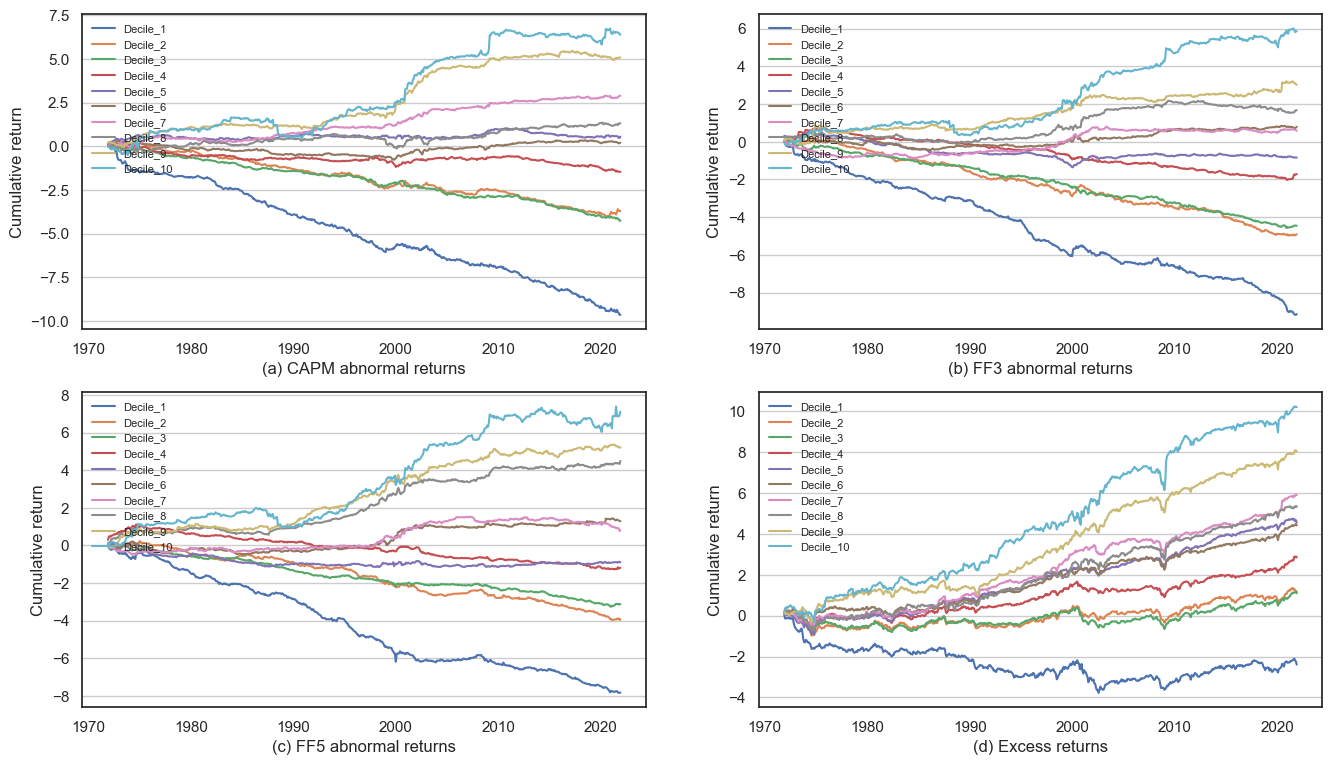

In [14]:
# plot cumulative return of value weighted portfolios
import seaborn as sns
from matplotlib import pyplot
sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(2,2,figsize=(16,9))

sns.lineplot(data=vw_portfolio_cumulative_cfnai, x='year_month', y='ab_capm', hue='capm_deciles', ax=axes[0,0])
sns.lineplot(data=vw_portfolio_cumulative_cfnai, x='year_month', y='ab_ff3', hue='ff3_deciles', ax=axes[0,1])
sns.lineplot(data=vw_portfolio_cumulative_cfnai, x='year_month', y='ab_ff5', hue='ff5_deciles', ax=axes[1,0])
sns.lineplot(data=vw_portfolio_cumulative_cfnai, x='year_month', y='ex_ret', hue='ex_deciles', ax=axes[1,1])

returns = [['(a) CAPM abnormal returns', '(b) FF3 abnormal returns'], ['(c) FF5 abnormal returns', '(d) Excess returns']]
for a in range(0,2):
  for b in range(0,2):
    axes[a][b].set(xlabel=returns[a][b], ylabel='Cumulative return')
    # hide legend title
    handles, labels = axes[a][b].get_legend_handles_labels()
    axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
    axes[a][b].grid(axis='y')

## 3. Predicting with firm features and Sentiment

In [15]:
# train 10 models to ensemble
n_members = 10
model_capm_sent, model_ff3_sent, model_ff5_sent, model_ex_sent = list(), list(), list(), list()

for i in range(0, n_members):
  # set seed for reproducibility
  set_seed(100 + i)
  # fit model with capm abnormal stock return
  model_c = model_fit(X=X_train_scaled[firm_features + sent], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[firm_features + sent], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
  # fit model with ff3 abnormal stock return
  model_3 = model_fit(X=X_train_scaled[firm_features + sent], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[firm_features + sent], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
  # fit model with capm abnormal stock return
  model_5 = model_fit(X=X_train_scaled[firm_features + sent], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[firm_features + sent], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
  # fit model with excess stock return
  model_e = model_fit(X=X_train_scaled[firm_features + sent], y=X_train_scaled['ex_return'], X_val=X_val_scaled[firm_features + sent], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
  
  # save models
  model_capm_sent.append(model_c)
  model_ff3_sent.append(model_3)
  model_ff5_sent.append(model_5)
  model_ex_sent.append(model_e)
  
clear_output()

In [16]:
# compute r-squared value and predictions in the test dataset
capm_yhats_sent = ensemble_predict(model_capm_sent, X_test_scaled[firm_features + sent])
ff3_yhats_sent = ensemble_predict(model_ff3_sent, X_test_scaled[firm_features + sent])
ff5_yhats_sent = ensemble_predict(model_ff5_sent, X_test_scaled[firm_features + sent])
ex_yhats_sent = ensemble_predict(model_ex_sent, X_test_scaled[firm_features + sent])

from sklearn.metrics import r2_score
capm_r2_sent = r2_score(X_test_scaled['ab_capm'], capm_yhats_sent)
ff3_r2_sent = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_sent)
ff5_r2_sent = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_sent)
ex_r2_sent = r2_score(X_test_scaled['ex_return'], ex_yhats_sent)

clear_output()

### 3.1 Equal weighted portfolios

In [17]:
ew_portfolio_sent = build_portfolios(capm_yhats_sent, ff3_yhats_sent, ff5_yhats_sent, ex_yhats_sent, weight='equal', test_data=X_test)
ew_portfolio_cumulative_sent = portfolio_cumulative_return(data=ew_portfolio_sent)
ew_portfolio_ls_sent = prediction_long_short(data=ew_portfolio_sent)

### 3.2 Value weighted portfolios

In [18]:
vw_portfolio_sent = build_portfolios(capm_yhats_sent, ff3_yhats_sent, ff5_yhats_sent, ex_yhats_sent, weight='value', test_data=X_test)
vw_portfolio_cumulative_sent = portfolio_cumulative_return(data=vw_portfolio_sent)
vw_portfolio_ls_sent = prediction_long_short(data=vw_portfolio_sent)

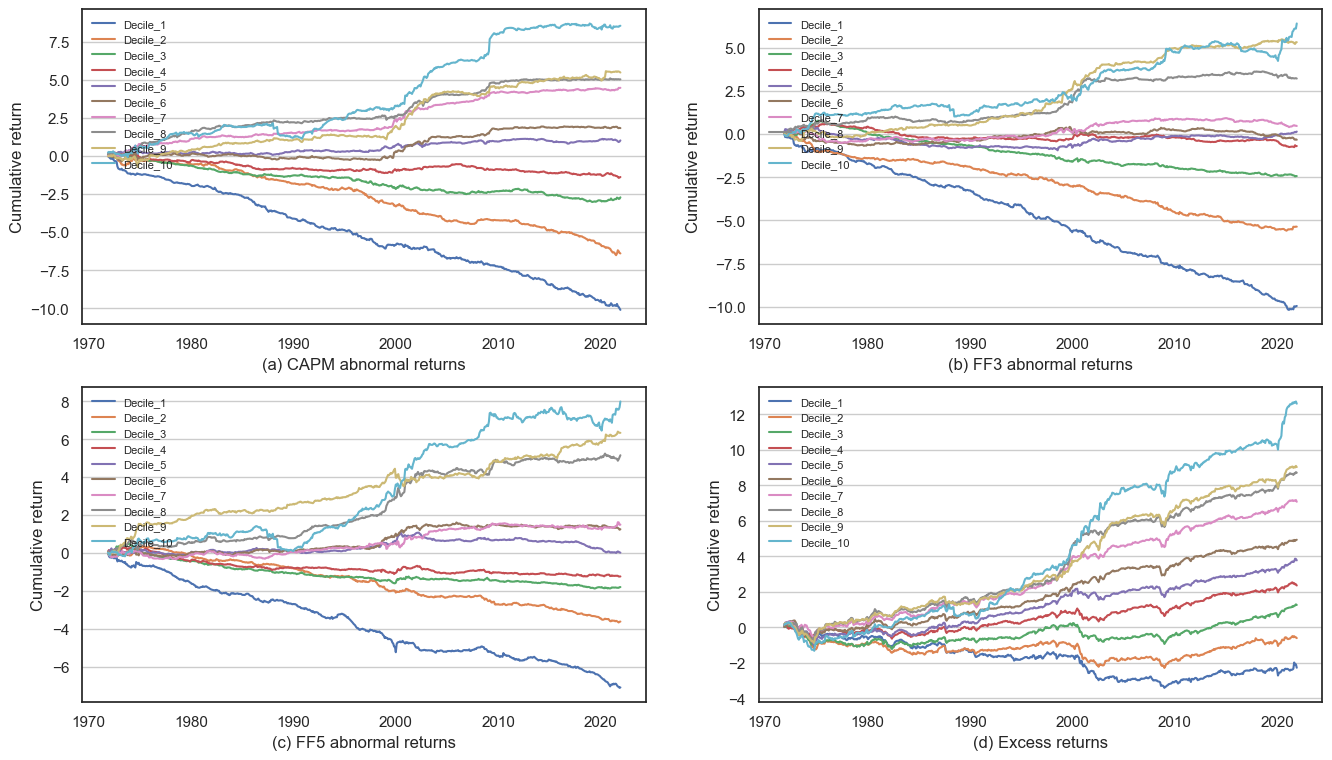

In [19]:
# plot cumulative return of value weighted portfolios
import seaborn as sns
from matplotlib import pyplot
sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(2,2,figsize=(16,9))

sns.lineplot(data=vw_portfolio_cumulative_sent, x='year_month', y='ab_capm', hue='capm_deciles', ax=axes[0,0])
sns.lineplot(data=vw_portfolio_cumulative_sent, x='year_month', y='ab_ff3', hue='ff3_deciles', ax=axes[0,1])
sns.lineplot(data=vw_portfolio_cumulative_sent, x='year_month', y='ab_ff5', hue='ff5_deciles', ax=axes[1,0])
sns.lineplot(data=vw_portfolio_cumulative_sent, x='year_month', y='ex_ret', hue='ex_deciles', ax=axes[1,1])

returns = [['(a) CAPM abnormal returns', '(b) FF3 abnormal returns'], ['(c) FF5 abnormal returns', '(d) Excess returns']]
for a in range(0,2):
  for b in range(0,2):
    axes[a][b].set(xlabel=returns[a][b], ylabel='Cumulative return')
    # hide legend title
    handles, labels = axes[a][b].get_legend_handles_labels()
    axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
    axes[a][b].grid(axis='y')

## 4. Predicting with firm features, CFNAI, and sentiment

In [20]:
# ensemble fit n models
n_models = 10
model_capm_all, model_ff3_all, model_ff5_all, model_ex_all = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[firm_features + cfnai + sent], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[firm_features + cfnai + sent], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[firm_features + cfnai + sent], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[firm_features + cfnai + sent], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[firm_features + cfnai + sent], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[firm_features + cfnai + sent], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[firm_features + cfnai + sent], y=X_train_scaled['ex_return'], X_val=X_val_scaled[firm_features + cfnai + sent], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_all.append(model_c)
    model_ff3_all.append(model_3)
    model_ff5_all.append(model_5)
    model_ex_all.append(model_e)
clear_output()

In [21]:
# compute r-squared value and predictions in the test dataset
capm_yhats_all = ensemble_predict(model_capm_all, X_test_scaled[firm_features + cfnai + sent])
ff3_yhats_all = ensemble_predict(model_ff3_all, X_test_scaled[firm_features + cfnai + sent])
ff5_yhats_all = ensemble_predict(model_ff5_all, X_test_scaled[firm_features + cfnai + sent])
ex_yhats_all = ensemble_predict(model_ex_all, X_test_scaled[firm_features + cfnai + sent])

from sklearn.metrics import r2_score
capm_r2_all = r2_score(X_test_scaled['ab_capm'], capm_yhats_all)
ff3_r2_all = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_all)
ff5_r2_all = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_all)
ex_r2_all = r2_score(X_test_scaled['ex_return'], ex_yhats_all)

clear_output()

### 4.1 Equal weighted portfolios

In [22]:
ew_portfolio_all = build_portfolios(capm_yhats_all, ff3_yhats_all, ff5_yhats_all, ex_yhats_all, weight='equal', test_data=X_test)
ew_portfolio_cumulative_all = portfolio_cumulative_return(data=ew_portfolio_all)
ew_portfolio_ls_all = prediction_long_short(data=ew_portfolio_all)

### 4.2 Value weighted portfolios

In [23]:
vw_portfolio_all = build_portfolios(capm_yhats_all, ff3_yhats_all, ff5_yhats_all, ex_yhats_all, weight='value', test_data=X_test)
vw_portfolio_cumulative_all = portfolio_cumulative_return(data=vw_portfolio_all)
vw_portfolio_ls_all = prediction_long_short(data=vw_portfolio_all)

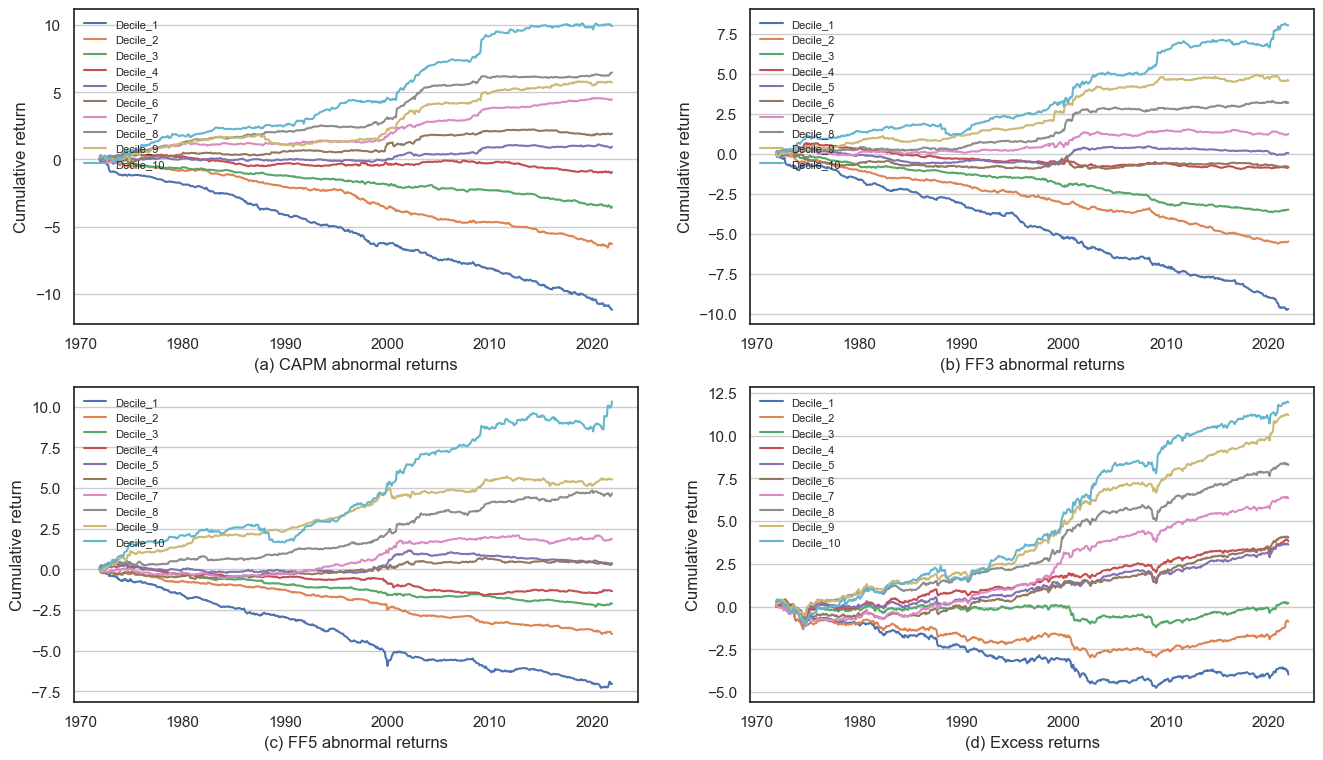

In [24]:
# plot cumulative returns of value weighted portfolios
import seaborn as sns
from matplotlib import pyplot
sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(2,2,figsize=(16,9))

sns.lineplot(data=vw_portfolio_cumulative_all, x='year_month', y='ab_capm', hue='capm_deciles', ax=axes[0,0])
sns.lineplot(data=vw_portfolio_cumulative_all, x='year_month', y='ab_ff3', hue='ff3_deciles', ax=axes[0,1])
sns.lineplot(data=vw_portfolio_cumulative_all, x='year_month', y='ab_ff5', hue='ff5_deciles', ax=axes[1,0])
sns.lineplot(data=vw_portfolio_cumulative_all, x='year_month', y='ex_ret', hue='ex_deciles', ax=axes[1,1])

returns = [['(a) CAPM abnormal returns', '(b) FF3 abnormal returns'], ['(c) FF5 abnormal returns', '(d) Excess returns']]
for a in range(0,2):
  for b in range(0,2):
    axes[a][b].set(xlabel=returns[a][b], ylabel='Cumulative return')
    # hide legend title
    handles, labels = axes[a][b].get_legend_handles_labels()
    axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
    axes[a][b].grid(axis='y')

In [85]:
# report R-squared values in test dataset with different preditor sets
pd.DataFrame({'Target': ['Firm', 'Firm + CFNAI', 'Firm + SENT', 'Firm + CFNAI + SENT'],
              'CAPM': [capm_r2_firm, capm_r2_cfnai, capm_r2_sent, capm_r2_all],
              'FF3': [ff3_r2_firm, ff3_r2_cfnai, ff3_r2_sent, ff3_r2_all],
              'FF5': [ff5_r2_firm, ff5_r2_cfnai, ff5_r2_sent, ff5_r2_all],
              'Excess Return': [ex_r2_firm, ex_r2_cfnai, ex_r2_sent, ex_r2_all]})

,Target,CAPM,FF3,FF5,Excess Return
0,Firm,0.009234,0.007627,0.007725,0.008114
1,Firm + CFNAI,0.009658,0.008156,0.008206,0.014575
2,Firm + SENT,0.012634,0.009380,0.009779,0.026505
3,Firm + CFNAI + SENT,0.013964,0.010108,0.009983,0.040051


In [100]:
# compare long-short portfolios based on model prediction (equal weighted)
ab_capm_ls = pd.DataFrame()
ab_capm_ls['Firm features'] = ew_portfolio_ls_firm['ab_capm']
ab_capm_ls['Firm + CFNAI'] = ew_portfolio_ls_cfnai['ab_capm']
ab_capm_ls['Firm + Sentiment'] = ew_portfolio_ls_sent['ab_capm']
ab_capm_ls['Firm + CFNAI + Sentiment'] = ew_portfolio_ls_all['ab_capm']

ab_ff3_ls = pd.DataFrame()
ab_ff3_ls['Firm features'] = ew_portfolio_ls_firm['ab_ff3']
ab_ff3_ls['Firm + CFNAI'] = ew_portfolio_ls_cfnai['ab_ff3']
ab_ff3_ls['Firm + Sentiment'] = ew_portfolio_ls_sent['ab_ff3']
ab_ff3_ls['Firm + CFNAI + Sentiment'] = ew_portfolio_ls_all['ab_ff3']

ab_ff5_ls = pd.DataFrame()
ab_ff5_ls['Firm features'] = ew_portfolio_ls_firm['ab_ff5']
ab_ff5_ls['Firm + CFNAI'] = ew_portfolio_ls_cfnai['ab_ff5']
ab_ff5_ls['Firm + Sentiment'] = ew_portfolio_ls_sent['ab_ff5']
ab_ff5_ls['Firm + CFNAI + Sentiment'] = ew_portfolio_ls_all['ab_ff5']

ex_ret_ls = pd.DataFrame()
ex_ret_ls['Firm features'] = ew_portfolio_ls_firm['ex_ret']
ex_ret_ls['Firm + CFNAI'] = ew_portfolio_ls_cfnai['ex_ret']
ex_ret_ls['Firm + Sentiment'] = ew_portfolio_ls_sent['ex_ret']
ex_ret_ls['Firm + CFNAI + Sentiment'] = ew_portfolio_ls_all['ex_ret']

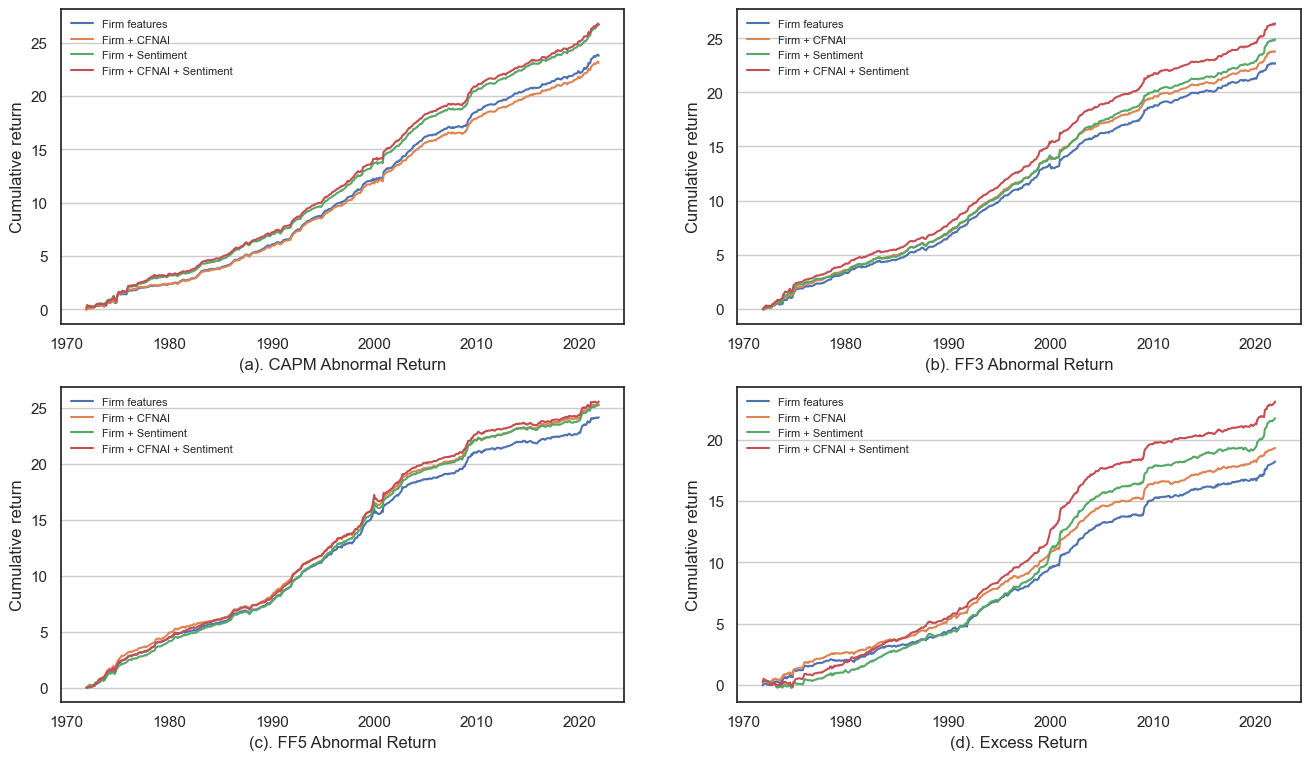

In [101]:
import seaborn as sns
from matplotlib import pyplot
sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(2,2,figsize=(16,9))

tidy1 = ab_capm_ls.cumsum().reset_index().melt(id_vars='year_month')
tidy2 = ab_ff3_ls.cumsum().reset_index().melt(id_vars='year_month')
tidy3 = ab_ff5_ls.cumsum().reset_index().melt(id_vars='year_month')
tidy4 = ex_ret_ls.cumsum().reset_index().melt(id_vars='year_month')

tidy = [[tidy1, tidy2], [tidy3, tidy4]]
xlabel = [['(a). CAPM Abnormal Return', '(b). FF3 Abnormal Return'],
          ['(c). FF5 Abnormal Return', '(d). Excess Return']]
for a in range(0,2):
  for b in range(0,2):
    sns.lineplot(data=tidy[a][b], x='year_month', y='value', hue='variable', ax=axes[a][b])
    axes[a][b].set(xlabel=xlabel[a][b], ylabel='Cumulative return')
    # hide legend title
    handles, labels = axes[a][b].get_legend_handles_labels()
    axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
    axes[a][b].grid(axis='y')

## 5 Features importance
### 5.1 Features importance of predicting FF5 abnormal return

In [28]:
# Features importance of predicting stock abnormal return 
import shap
# print the JS visualization code to the notebook
shap.initjs()

# randomly draw 100 observations to compute feature importance
background = X_train_scaled.iloc[np.random.choice(X_train_scaled.shape[0], 100, replace=False)][firm_features + cfnai + sent]
# based on which importance is checked
X_importance = X_test_scaled.iloc[np.random.choice(X_test_scaled.shape[0], 100, replace=False)][firm_features + cfnai + sent]

explainer_ff5 = [shap.KernelExplainer(model, background) for model in model_ff5_all]
shap_values_ff5 = [explain.shap_values(X_importance, nsamples=100) for explain in explainer_ff5]
shap_values_ff5 = np.array(shap_values_ff5)
# take average across ensemble members
shap_values_ff5 = np.mean(shap_values_ff5, axis=0)
clear_output()

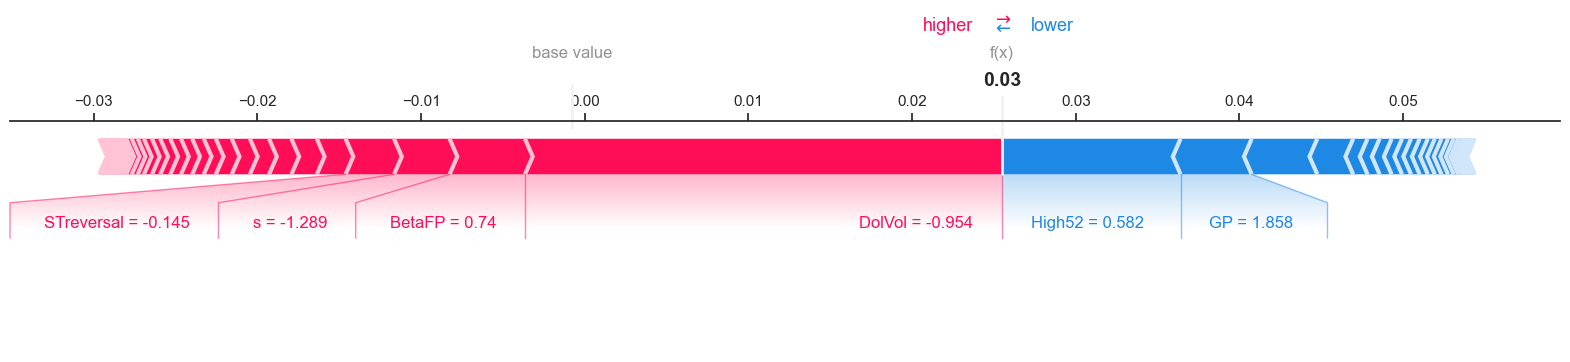

In [29]:
# plot the SHAP values for output of i
i = 20
shap.force_plot(np.array([explain.expected_value[0] for explain in explainer_ff5]).mean(), shap_values_ff5[0][i,:], np.round(X_test_scaled.iloc[i,:][firm_features + cfnai + sent],3), matplotlib=True, feature_names=firm_features + cfnai + sent)

In [86]:
# get shap feature importance
shap_ff5 = np.abs(shap_values_ff5)[0].mean(axis=0)
importance_ff5 = pd.DataFrame([firm_features + cfnai + sent, shap_ff5.tolist()]).T
importance_ff5.columns = ['column_name', 'shap_importance']
importance_ff5 = importance_ff5.sort_values('shap_importance', ascending=False)

# load variable group data
variable_group = pd.read_excel('data/raw_data/variable_group.xlsx')
importance_ff5 = importance_ff5.merge(variable_group, left_on='column_name', right_on='Variable', how='left')
importance_ff5['Group'].fillna('CFNAI', inplace=True)

# compute group importance
group_ff5 = importance_ff5.groupby('Group')['shap_importance'].mean()
group_ff5.sort_values(ascending=False, inplace=True)

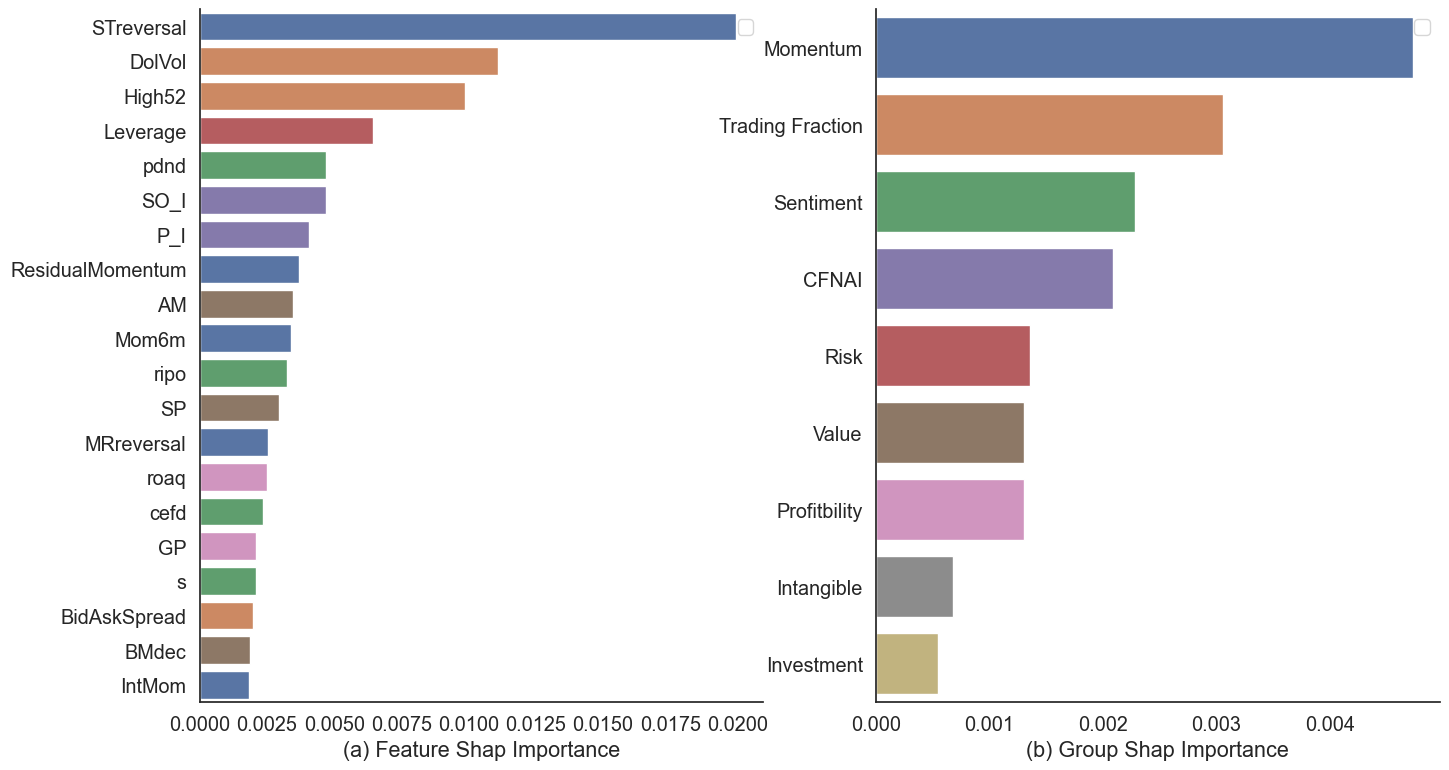

In [87]:
# plot feature importance
import seaborn as sns
from matplotlib import pyplot

sns.set_theme(font_scale=1.3, style='white')
fig, axes = pyplot.subplots(1,2,figsize=(16,9))

palette_1 = ['#4c72b0', '#dd8452', '#c44e52', '#55a868', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974']
sns.barplot(data = importance_ff5[0:20], x='shap_importance', y='column_name', hue='Group', dodge=False, ax=axes[0], palette=palette_1)
palette_2 = ['#4c72b0', '#dd8452', '#55a868', '#8172b3', '#c44e52', '#937860', '#da8bc3', '#8c8c8c', '#ccb974']
sns.barplot(x=group_ff5, y=group_ff5.index, orient='h', ax=axes[1], palette=palette_2)

for ax in axes:
  ax.set_ylabel('')
  ax.legend('')
axes[0].set_xlabel('(a) Feature Shap Importance')
axes[1].set_xlabel('(b) Group Shap Importance')
sns.despine(fig)

In [32]:
import matplotlib
rgb_colors = sns.color_palette()
list(map(matplotlib.colors.rgb2hex, rgb_colors))

['#4c72b0',
 '#dd8452',
 '#55a868',
 '#c44e52',
 '#8172b3',
 '#937860',
 '#da8bc3',
 '#8c8c8c',
 '#ccb974',
 '#64b5cd']

### 5.2 Features importance of predicting stock excess return

In [33]:
explainer_ex = [shap.KernelExplainer(model, background) for model in model_ex_all]
shap_values_ex = [explain.shap_values(X_importance, nsamples=100) for explain in explainer_ex]
shap_values_ex = np.array(shap_values_ex)
# take average across ensemble members
shap_values_ex = np.mean(shap_values_ex, axis=0)
clear_output()

In [66]:
# get shap feature importance
shap_ex = np.abs(shap_values_ex)[0].mean(axis=0)
importance_ex = pd.DataFrame([firm_features + cfnai + sent, shap_ex.tolist()]).T
importance_ex.columns = ['column_name', 'shap_importance']
importance_ex = importance_ex.sort_values('shap_importance', ascending=False)

# load variable group data
variable_group = pd.read_excel('data/raw_data/variable_group.xlsx')
importance_ex = importance_ex.merge(variable_group, left_on='column_name', right_on='Variable', how='left')

# compute group importance
group_ex = importance_ex.groupby('Group')['shap_importance'].mean()
group_ex.sort_values(ascending=False, inplace=True)

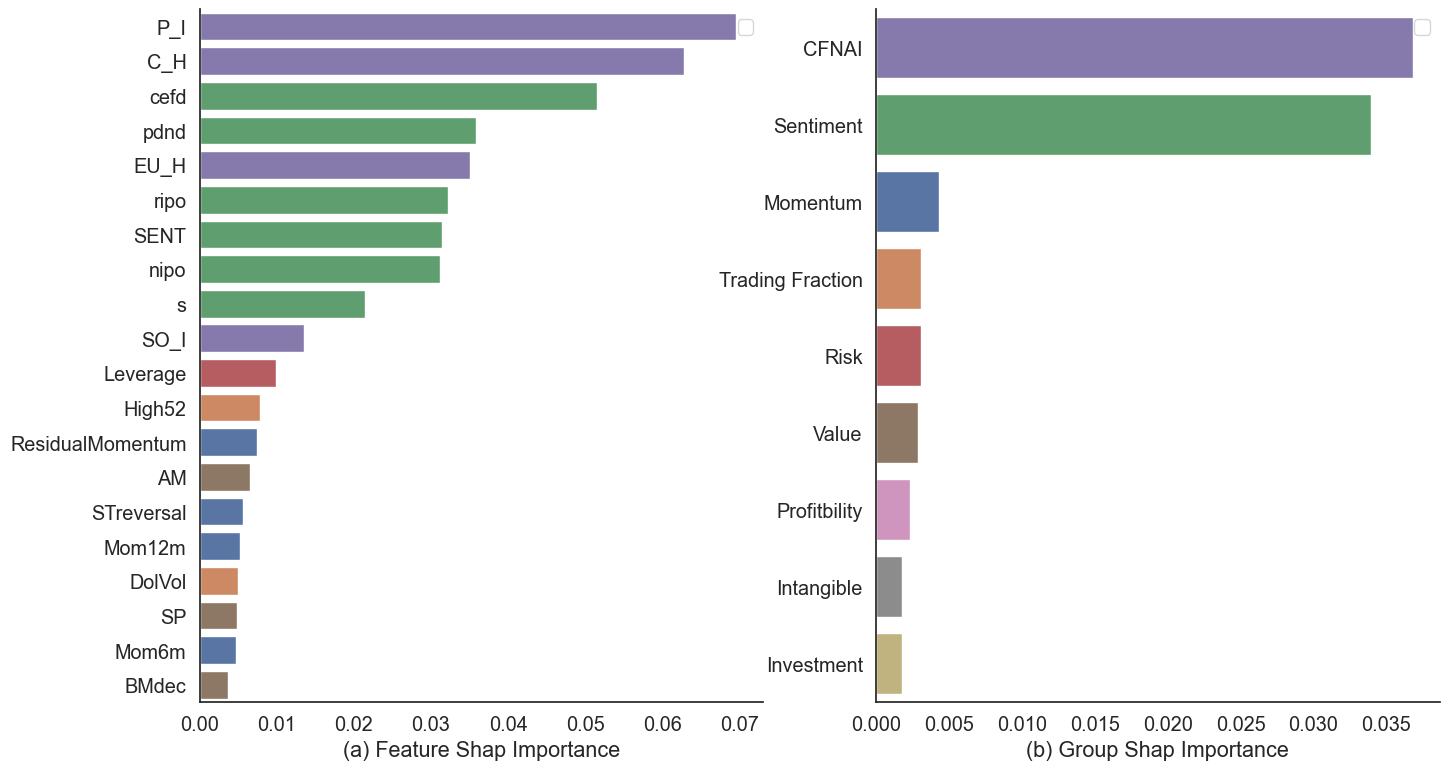

In [68]:
# plot feature importance
import seaborn as sns
from matplotlib import pyplot

sns.set_theme(font_scale=1.3, style='white')
fig, axes = pyplot.subplots(1,2,figsize=(16,9))

palette_1 = ['#8172b3', '#55a868', '#c44e52', '#dd8452', '#4c72b0', '#937860', '#da8bc3', '#8c8c8c', '#ccb974']
sns.barplot(data = importance_ex[0:20], x='shap_importance', y='column_name', hue='Group', dodge=False, ax=axes[0], palette=palette_1)
palette_2 = ['#8172b3', '#55a868', '#4c72b0', '#dd8452', '#c44e52', '#937860', '#da8bc3', '#8c8c8c', '#ccb974']
sns.barplot(x=group_ex, y=group_ex.index, orient='h', ax=axes[1], palette=palette_2)

for ax in axes:
  ax.set_ylabel('')
  ax.legend('')
axes[0].set_xlabel('(a) Feature Shap Importance')
axes[1].set_xlabel('(b) Group Shap Importance')
sns.despine(fig)

### 5.3 Features importance of predicting CAPM abnormal return

In [36]:
explainer_capm = [shap.KernelExplainer(model, background) for model in model_capm_all]
shap_values_capm = [explain.shap_values(X_importance, nsamples=100) for explain in explainer_capm]
shap_values_capm = np.array(shap_values_capm)
# take average across ensemble members
shap_values_capm = np.mean(shap_values_capm, axis=0)
clear_output()

In [69]:
# get shap feature importance
shap_capm = np.abs(shap_values_capm)[0].mean(axis=0)
importance_capm = pd.DataFrame([firm_features + cfnai + sent, shap_capm.tolist()]).T
importance_capm.columns = ['column_name', 'shap_importance']
importance_capm = importance_capm.sort_values('shap_importance', ascending=False)

# load variable group data
variable_group = pd.read_excel('data/raw_data/variable_group.xlsx')
importance_capm = importance_capm.merge(variable_group, left_on='column_name', right_on='Variable', how='left')

# compute group importance
group_capm = importance_capm.groupby('Group')['shap_importance'].mean()
group_capm.sort_values(ascending=False, inplace=True)

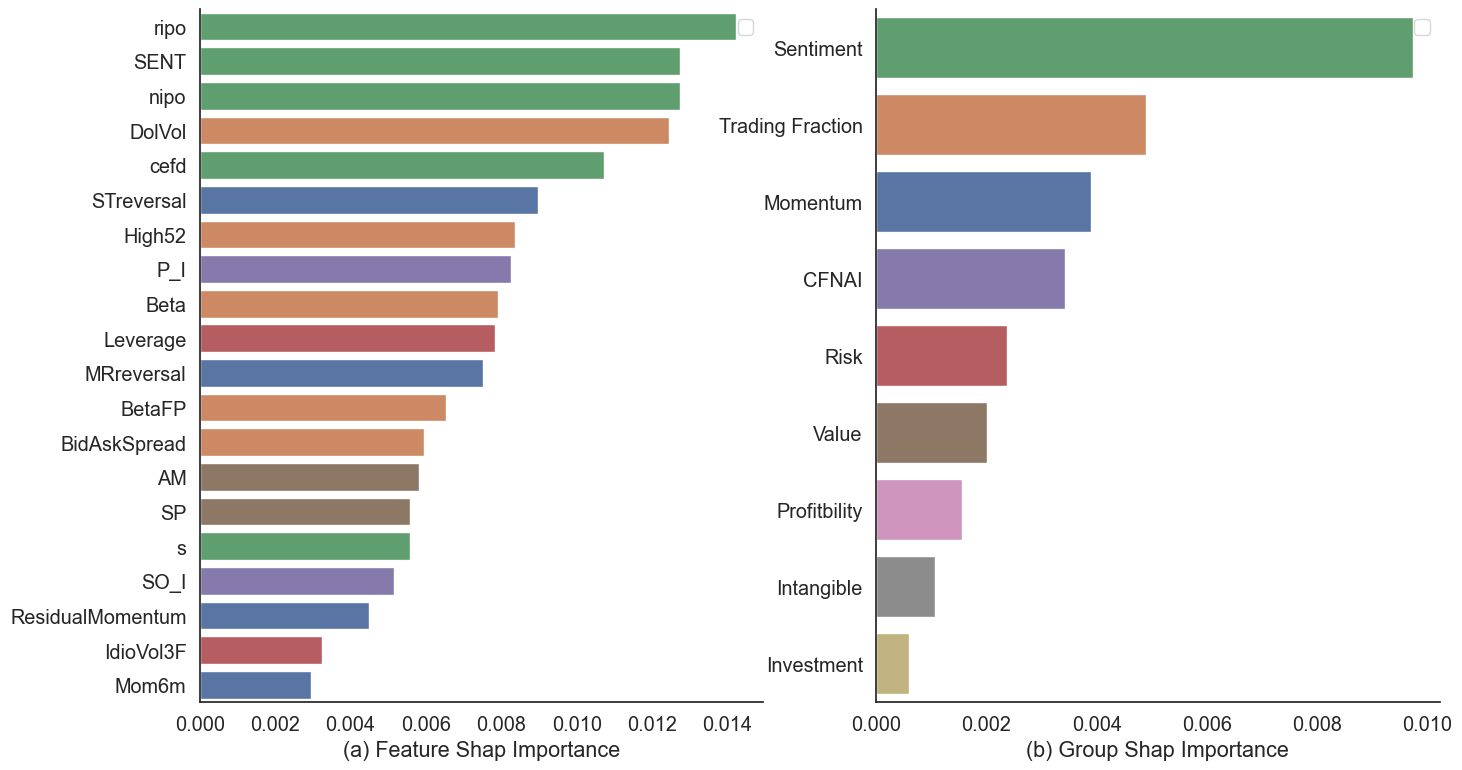

In [71]:
# plot feature importance
import seaborn as sns
from matplotlib import pyplot

sns.set_theme(font_scale=1.3, style='white')
fig, axes = pyplot.subplots(1,2,figsize=(16,9))

palette_1 = ['#55a868', '#dd8452', '#4c72b0', '#8172b3', '#c44e52', '#937860', '#da8bc3', '#8c8c8c', '#ccb974']
sns.barplot(data = importance_capm[0:20], x='shap_importance', y='column_name', hue='Group', dodge=False, ax=axes[0], palette=palette_1)
palette_2 = ['#55a868', '#dd8452', '#4c72b0', '#8172b3', '#c44e52', '#937860', '#da8bc3', '#8c8c8c', '#ccb974']
sns.barplot(x=group_capm, y=group_capm.index, orient='h', ax=axes[1], palette=palette_2)

for ax in axes:
  ax.set_ylabel('')
  ax.legend('')
axes[0].set_xlabel('(a) Feature Shap Importance')
axes[1].set_xlabel('(b) Group Shap Importance')
sns.despine(fig)

### 5.4 Features importance of predicting FF3 abnormal return

In [39]:
explainer_ff3 = [shap.KernelExplainer(model, background) for model in model_ff3_all]
shap_values_ff3 = [explain.shap_values(X_importance, nsamples=100) for explain in explainer_ff3]
shap_values_ff3 = np.array(shap_values_ff3)
# take average across ensemble members
shap_values_ff3 = np.mean(shap_values_ff3, axis=0)
clear_output()

In [88]:
# get shap feature importance
shap__ff3 = np.abs(shap_values_ff3)[0].mean(axis=0)
importance_ff3 = pd.DataFrame([firm_features + cfnai + sent, shap__ff3.tolist()]).T
importance_ff3.columns = ['column_name', 'shap_importance']
importance_ff3 = importance_ff3.sort_values('shap_importance', ascending=False)

# load variable group data
variable_group = pd.read_excel('data/raw_data/variable_group.xlsx')
importance_ff3 = importance_ff3.merge(variable_group, left_on='column_name', right_on='Variable', how='left')
importance_ff3['Group'].fillna('CFNAI', inplace=True)

# compute group importance
group_ff3 = importance_ff3.groupby('Group')['shap_importance'].mean()
group_ff3.sort_values(ascending=False, inplace=True)

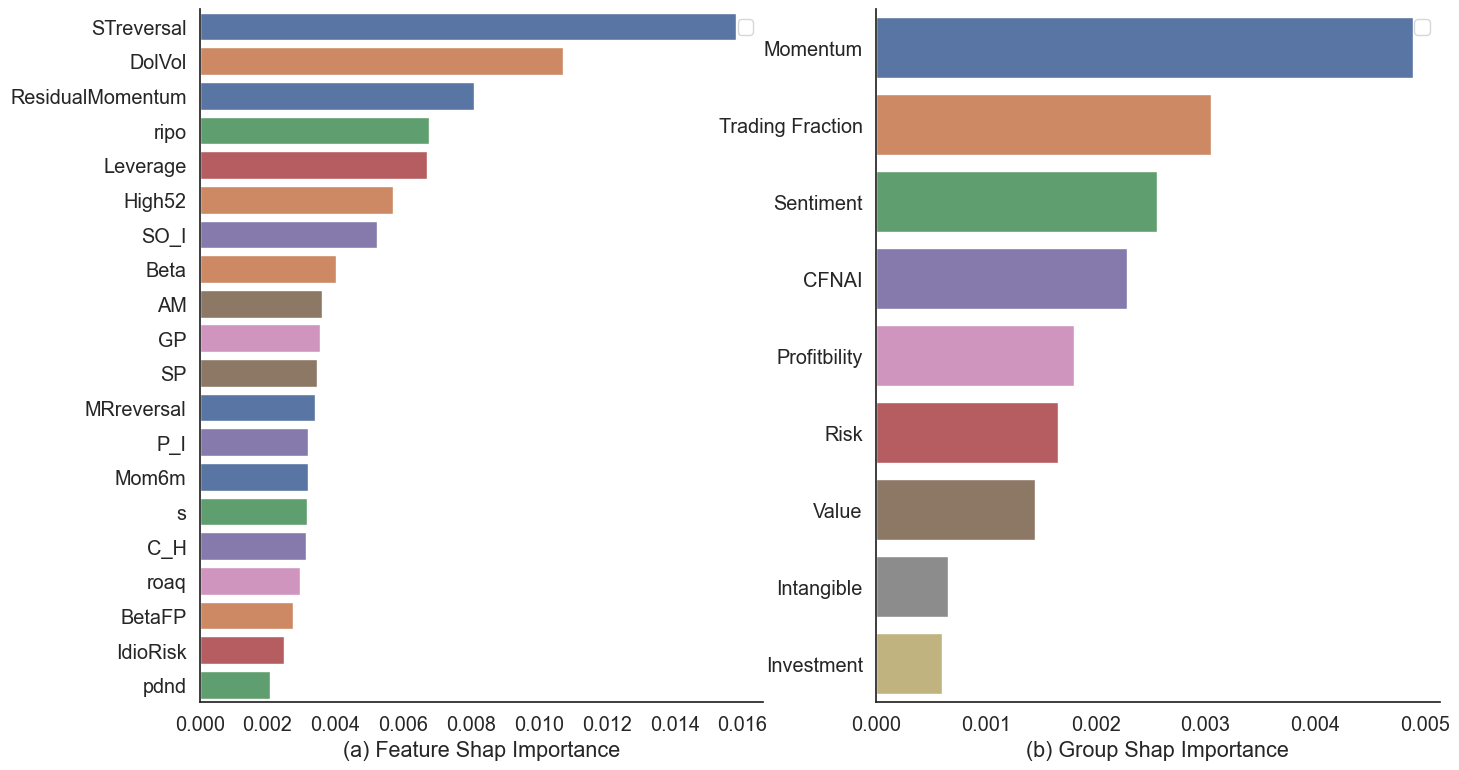

In [89]:
# plot feature importance
import seaborn as sns
from matplotlib import pyplot

sns.set_theme(font_scale=1.3, style='white')
fig, axes = pyplot.subplots(1,2,figsize=(16,9))

palette_1 = ['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974']
sns.barplot(data = importance_ff3[0:20], x='shap_importance', y='column_name', hue='Group', dodge=False, ax=axes[0], palette=palette_1)
palette_2 = ['#4c72b0', '#dd8452', '#55a868', '#8172b3', '#da8bc3', '#c44e52', '#937860', '#8c8c8c', '#ccb974']
sns.barplot(x=group_ff3, y=group_ff3.index, orient='h', ax=axes[1], palette=palette_2)

for ax in axes:
  ax.set_ylabel('')
  ax.legend('')
axes[0].set_xlabel('(a) Feature Shap Importance')
axes[1].set_xlabel('(b) Group Shap Importance')
sns.despine(fig)

## 6 Interaction Effect
### 6.1 Interaction Effect for FF5 Abnormal Return

In [42]:
# create an artifical dataset
pseudo = X_test_scaled[firm_features + cfnai].copy()
pseudo['group'] = 'a'
# firm feature variables are filled median 
pseudo = pseudo.groupby('group').transform('median')
# only take 1000 observations
pseudo = pseudo.iloc[0:1000]

pseudo_yhat = list()
for variable in ['High52', 'ResidualMomentum', 'MRreversal', 'STreversal']:
  temp = pseudo.copy()
  temp[variable] = np.linspace(-1,1,1000)
  
  yhat_ab = list()
  for percentile in (0.1, 0.3, 0.5, 0.7, 0.9):
# macro variables in each percentile 
    temp['CFNAI'] = X_test_scaled['CFNAI'].quantile(percentile)
      
    yhat = ensemble_predict(model_ff5_cfnai, temp)
    yhat_ab.append(yhat)
  pseudo_yhat.append(yhat_ab)
  
clear_output()

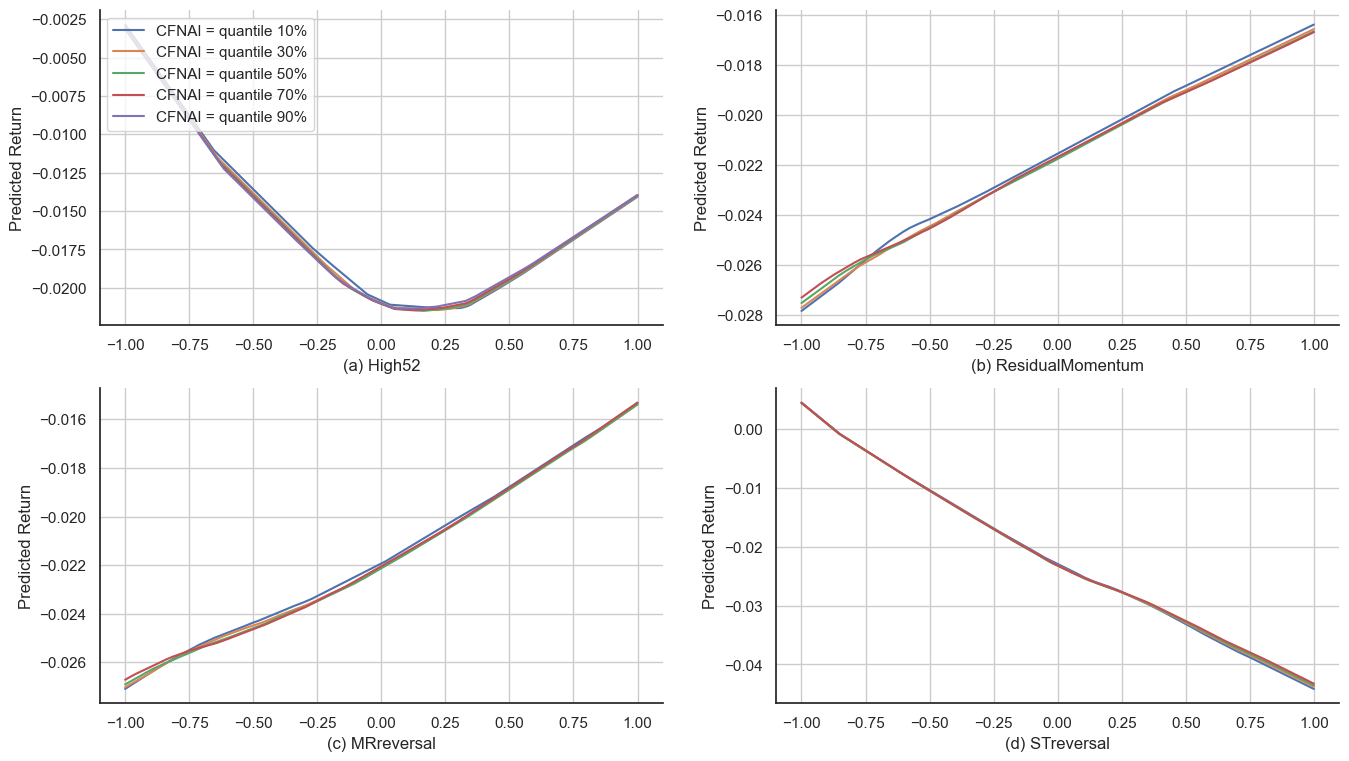

In [43]:
import seaborn as sns
from matplotlib import pyplot
sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(2,2,figsize=(16,9))

sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][0]), ax=axes[0,0], label='CFNAI = quantile 10%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][1]), ax=axes[0,0], label='CFNAI = quantile 30%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][2]), ax=axes[0,0], label='CFNAI = quantile 50%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][3]), ax=axes[0,0], label='CFNAI = quantile 70%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][4]), ax=axes[0,0], label='CFNAI = quantile 90%')
axes[0][0].set_xlabel('(a) High52')
axes[0][0].set_ylabel('Predicted Return')
axes[0][0].legend(loc='upper left')
axes[0][0].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[1][i]), ax=axes[0,1])
axes[0][1].set_ylabel('Predicted Return')
axes[0][1].set_xlabel('(b) ResidualMomentum')
axes[0][1].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[2][i]), ax=axes[1,0])
axes[1][0].set_ylabel('Predicted Return')
axes[1][0].set_xlabel('(c) MRreversal')
axes[1][0].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[3][i]), ax=axes[1,1])
axes[1][1].set_ylabel('Predicted Return')
axes[1][1].set_xlabel('(d) STreversal')
axes[1][1].grid()

sns.despine(fig)

### 6.2 Interaction Effect for Stock Excess Return

In [44]:
pseudo_yhat = list()
for variable in ['High52', 'ResidualMomentum', 'MRreversal', 'STreversal']:
  temp = pseudo.copy()
  temp[variable] = np.linspace(-1,1,1000)
  
  yhat_ex = list()
  for percentile in (0.1, 0.3, 0.5, 0.7, 0.9):
    temp['CFNAI'] = X_test_scaled['CFNAI'].quantile(percentile)
      
    yhat = ensemble_predict(model_ex_cfnai, temp)
    yhat_ex.append(yhat)
  pseudo_yhat.append(yhat_ex)
clear_output()

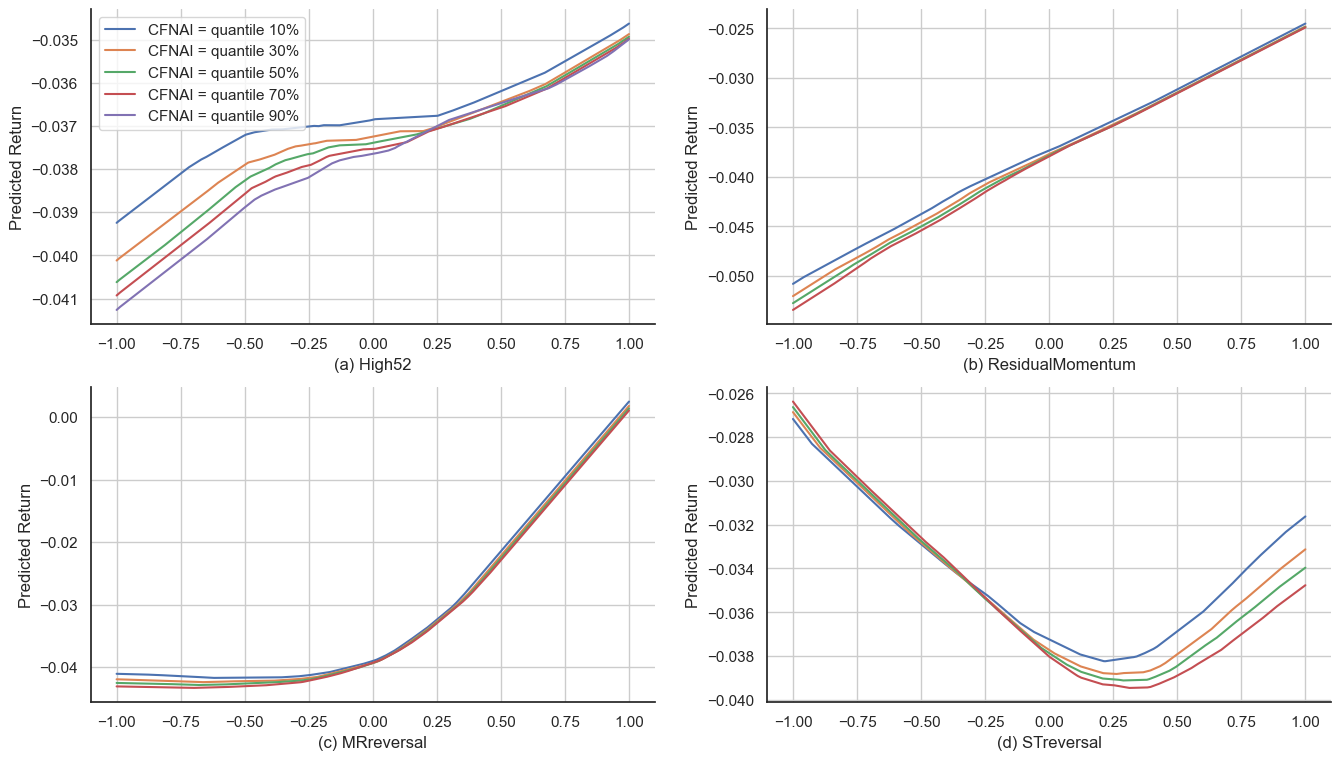

In [45]:
import seaborn as sns
from matplotlib import pyplot
sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(2,2,figsize=(16,9))

sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][0]), ax=axes[0,0], label='CFNAI = quantile 10%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][1]), ax=axes[0,0], label='CFNAI = quantile 30%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][2]), ax=axes[0,0], label='CFNAI = quantile 50%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][3]), ax=axes[0,0], label='CFNAI = quantile 70%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][4]), ax=axes[0,0], label='CFNAI = quantile 90%')
axes[0][0].set_xlabel('(a) High52')
axes[0][0].set_ylabel('Predicted Return')
axes[0][0].legend(loc='upper left')
axes[0][0].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[1][i]), ax=axes[0,1])
axes[0][1].set_ylabel('Predicted Return')
axes[0][1].set_xlabel('(b) ResidualMomentum')
axes[0][1].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[2][i]), ax=axes[1,0])
axes[1][0].set_ylabel('Predicted Return')
axes[1][0].set_xlabel('(c) MRreversal')
axes[1][0].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[3][i]), ax=axes[1,1])
axes[1][1].set_ylabel('Predicted Return')
axes[1][1].set_xlabel('(d) STreversal')
axes[1][1].grid()

sns.despine(fig)

### 6.3 Interaction Effect for FF3 Abnormal Return

In [46]:
# create an artifical dataset
pseudo = X_test_scaled[firm_features + cfnai].copy()
pseudo['group'] = 'a'
# firm feature variables are filled median 
pseudo = pseudo.groupby('group').transform('median')
# only take 1000 observations
pseudo = pseudo.iloc[0:1000]

pseudo_yhat = list()
for variable in ['High52', 'ResidualMomentum', 'MRreversal', 'STreversal']:
  temp = pseudo.copy()
  temp[variable] = np.linspace(-1,1,1000)
  
  yhat_ab = list()
  for percentile in (0.1, 0.3, 0.5, 0.7, 0.9):
# macro variables in each percentile 
    temp['CFNAI'] = X_test_scaled['CFNAI'].quantile(percentile)
      
    yhat = ensemble_predict(model_ff3_cfnai, temp)
    yhat_ab.append(yhat)
  pseudo_yhat.append(yhat_ab)
  
clear_output()

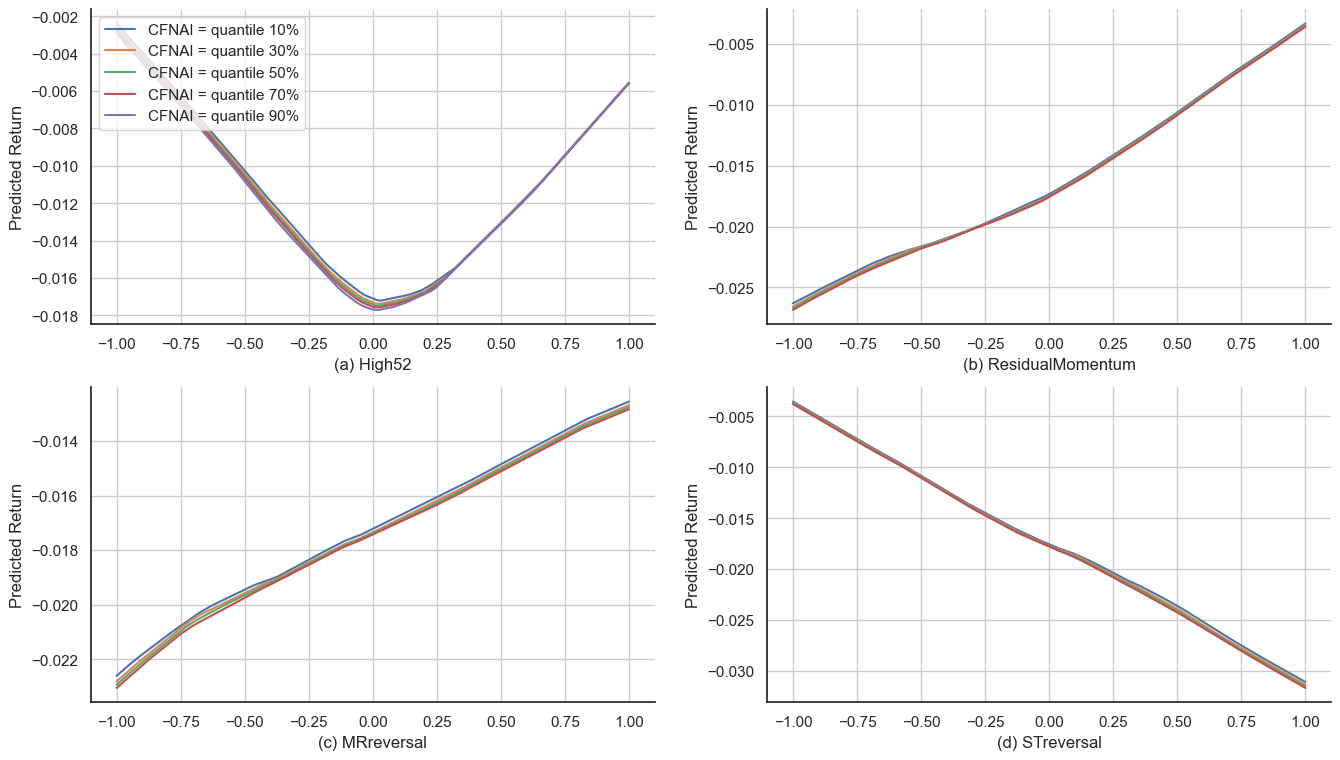

In [47]:
import seaborn as sns
from matplotlib import pyplot
sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(2,2,figsize=(16,9))

sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][0]), ax=axes[0,0], label='CFNAI = quantile 10%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][1]), ax=axes[0,0], label='CFNAI = quantile 30%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][2]), ax=axes[0,0], label='CFNAI = quantile 50%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][3]), ax=axes[0,0], label='CFNAI = quantile 70%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][4]), ax=axes[0,0], label='CFNAI = quantile 90%')
axes[0][0].set_xlabel('(a) High52')
axes[0][0].set_ylabel('Predicted Return')
axes[0][0].legend(loc='upper left')
axes[0][0].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[1][i]), ax=axes[0,1])
axes[0][1].set_ylabel('Predicted Return')
axes[0][1].set_xlabel('(b) ResidualMomentum')
axes[0][1].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[2][i]), ax=axes[1,0])
axes[1][0].set_ylabel('Predicted Return')
axes[1][0].set_xlabel('(c) MRreversal')
axes[1][0].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[3][i]), ax=axes[1,1])
axes[1][1].set_ylabel('Predicted Return')
axes[1][1].set_xlabel('(d) STreversal')
axes[1][1].grid()

sns.despine(fig)

### 6.4 Interaction Effect for CAPM Abnormal Return

In [48]:
# create an artifical dataset
pseudo = X_test_scaled[firm_features + cfnai].copy()
pseudo['group'] = 'a'
# firm feature variables are filled median 
pseudo = pseudo.groupby('group').transform('median')
# only take 1000 observations
pseudo = pseudo.iloc[0:1000]

pseudo_yhat = list()
for variable in ['High52', 'ResidualMomentum', 'MRreversal', 'STreversal']:
  temp = pseudo.copy()
  temp[variable] = np.linspace(-1,1,1000)
  
  yhat_ab = list()
  for percentile in (0.1, 0.3, 0.5, 0.7, 0.9):
# macro variables in each percentile 
    temp['CFNAI'] = X_test_scaled['CFNAI'].quantile(percentile)
      
    yhat = ensemble_predict(model_capm_cfnai, temp)
    yhat_ab.append(yhat)
  pseudo_yhat.append(yhat_ab)
  
clear_output()

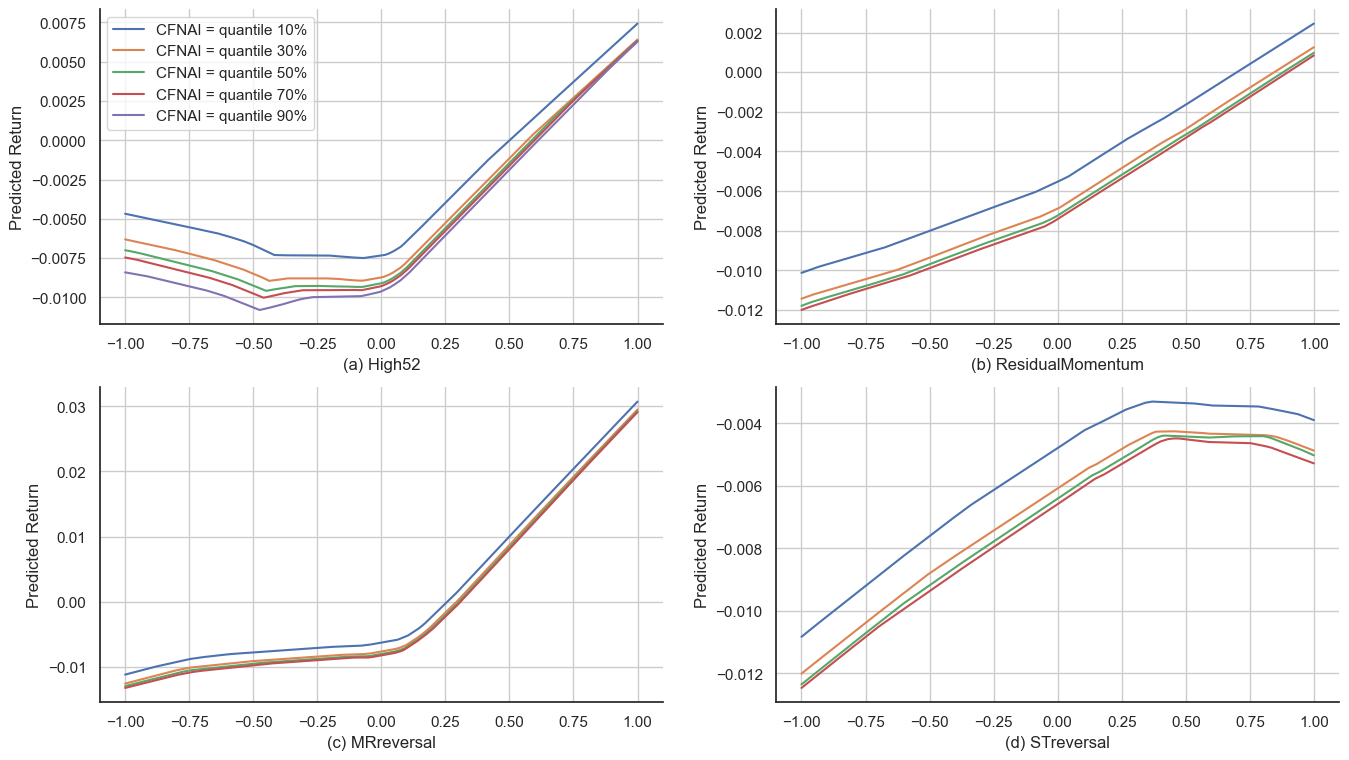

In [49]:
import seaborn as sns
from matplotlib import pyplot
sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(2,2,figsize=(16,9))

sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][0]), ax=axes[0,0], label='CFNAI = quantile 10%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][1]), ax=axes[0,0], label='CFNAI = quantile 30%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][2]), ax=axes[0,0], label='CFNAI = quantile 50%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][3]), ax=axes[0,0], label='CFNAI = quantile 70%')
sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[0][4]), ax=axes[0,0], label='CFNAI = quantile 90%')
axes[0][0].set_xlabel('(a) High52')
axes[0][0].set_ylabel('Predicted Return')
axes[0][0].legend(loc='upper left')
axes[0][0].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[1][i]), ax=axes[0,1])
axes[0][1].set_ylabel('Predicted Return')
axes[0][1].set_xlabel('(b) ResidualMomentum')
axes[0][1].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[2][i]), ax=axes[1,0])
axes[1][0].set_ylabel('Predicted Return')
axes[1][0].set_xlabel('(c) MRreversal')
axes[1][0].grid()

for i in range(0,4):
  sns.lineplot(x=np.linspace(-1,1,1000), y=np.squeeze(pseudo_yhat[3][i]), ax=axes[1,1])
axes[1][1].set_ylabel('Predicted Return')
axes[1][1].set_xlabel('(d) STreversal')
axes[1][1].grid()

sns.despine(fig)

## 7 Marketing time 

In [90]:
# market timing based on CFNAI for ff5 abnormal return
# cut test data into tertiles
X_test_scaled['tertiles'] = pd.qcut(X_test_scaled['CFNAI'], 3, labels=False)
X_test['tertiles'] = pd.qcut(X_test_scaled['CFNAI'], 3, labels=False)

yhats_ff5_ter = list()
for i in range(0,3):
  # predict abnormal return in each tertiles
  yhats = ensemble_predict(model_ff5_cfnai, X_test_scaled[X_test_scaled['tertiles']==i][firm_features + cfnai])
  yhats_ff5_ter.append(yhats)
clear_output()

In [91]:
portflios = list()
for i in range(0,3):
  tertiles = pd.DataFrame()
  # get the actual abnormal return from test dataset
  tertiles['ab_ff5'] = X_test[X_test['tertiles']==i]['ab_ff5']
  # get predicted abnormal return
  tertiles['yhat'] = yhats_ff5_ter[i]
  # cut predicted abnormal return into deciles
  tertiles['deciles'] = tertiles.groupby('year_month')['yhat'].transform(lambda g: pd.qcut(g, q=10, labels=list(f'Decile_{i}' for i in range(1,11))))
  # mean return and sharpe ratio in each deciles
  equal_weighted = tertiles.groupby(['deciles', 'year_month']).agg(mean_ret=pd.NamedAgg(column='ab_ff5', aggfunc='mean')).reset_index()
  
  # mean and sharpe ratio across all time in each deciles
  portf = pd.DataFrame(equal_weighted.groupby('deciles')['mean_ret'].mean())
  portf['std_ret'] = equal_weighted.groupby('deciles')['mean_ret'].std()
  portf['sharp'] = portf['mean_ret']/portf['std_ret']
  portf.drop('std_ret', axis=1, inplace=True)
  
  portflios.append(portf)

# merge data from all tertiles
cfnai_tertiles = pd.merge(portflios[0], portflios[1], left_index=True, right_index=True)
cfnai_tertiles = pd.merge(cfnai_tertiles, portflios[2], left_index=True, right_index=True)

cfnai_tertiles.columns = ['mean_ret_ter1', 'sharpe_ter1', 'mean_ret_ter2', 'sharpe_ter', 'mean_ret_ter3', 'sharpe_ter3']
cfnai_tertiles

,mean_ret_ter1,sharpe_ter1,mean_ret_ter2,sharpe_ter,mean_ret_ter3,sharpe_ter3
deciles,,,,,,
Decile_1,-2.090333,-0.420175,-1.785757,-0.492165,-1.648707,-0.413075
Decile_2,-0.653563,-0.246082,-0.730982,-0.366263,-0.644894,-0.248319
Decile_3,-0.632163,-0.260457,-0.386833,-0.206501,-0.429005,-0.200890
Decile_4,-0.221810,-0.087879,-0.263761,-0.172192,-0.067429,-0.021885
Decile_5,-0.131367,-0.054764,0.080488,0.046092,-0.072864,-0.033680
Decile_6,0.096245,0.040081,-0.034039,-0.020218,0.121580,0.047958
Decile_7,0.253141,0.099935,0.144483,0.073218,0.008892,0.003825
Decile_8,0.584577,0.147763,0.715117,0.331936,0.413328,0.157733
Decile_9,0.734820,0.164986,0.850996,0.305131,0.803271,0.306451


In [92]:
# market timing based on CFNAI for excess return
# cut test data into tertiles
X_test_scaled['tertiles'] = pd.qcut(X_test_scaled['CFNAI'], 3, labels=False)
X_test['tertiles'] = pd.qcut(X_test_scaled['CFNAI'], 3, labels=False)

yhats_ex_ter = list()
for i in range(0,3):
  # predict abnormal return in each tertiles
  yhats = ensemble_predict(model_ex_cfnai, X_test_scaled[X_test_scaled['tertiles']==i][firm_features + cfnai])
  yhats_ex_ter.append(yhats)
clear_output()

In [93]:
portflios = list()
for i in range(0,3):
  tertiles = pd.DataFrame()
  # get the actual excess return from test dataset
  tertiles['ex_return'] = X_test[X_test['tertiles']==i]['ex_return']
  # get predicted abnormal return
  tertiles['yhat'] = yhats_ff5_ter[i]
  # cut predicted abnormal return into deciles
  tertiles['deciles'] = tertiles.groupby('year_month')['yhat'].transform(lambda g: pd.qcut(g, q=10, labels=list(f'Decile_{i}' for i in range(1,11))))
  # mean return and sharpe ratio in each deciles
  equal_weighted = tertiles.groupby(['deciles', 'year_month']).agg(mean_ret=pd.NamedAgg(column='ex_return', aggfunc='mean')).reset_index()
  
  # mean and sharpe ratio across all time in each deciles
  portf = pd.DataFrame(equal_weighted.groupby('deciles')['mean_ret'].mean())
  portf['std_ret'] = equal_weighted.groupby('deciles')['mean_ret'].std()
  portf['sharp'] = portf['mean_ret']/portf['std_ret']
  portf.drop('std_ret', axis=1, inplace=True)
  
  portflios.append(portf)

# merge data from all tertiles
cfnai_tertiles = pd.merge(portflios[0], portflios[1], left_index=True, right_index=True)
cfnai_tertiles = pd.merge(cfnai_tertiles, portflios[2], left_index=True, right_index=True)

cfnai_tertiles.columns = ['mean_ret_ter1', 'sharpe_ter1', 'mean_ret_ter2', 'sharpe_ter', 'mean_ret_ter3', 'sharpe_ter3']
cfnai_tertiles

,mean_ret_ter1,sharpe_ter1,mean_ret_ter2,sharpe_ter,mean_ret_ter3,sharpe_ter3
deciles,,,,,,
Decile_1,-0.789057,-0.112981,-0.517868,-0.075635,-0.636611,-0.085723
Decile_2,0.483078,0.069206,0.273382,0.050905,-0.070901,-0.011951
Decile_3,0.618027,0.099841,0.395503,0.088547,0.034751,0.005971
Decile_4,0.869507,0.132940,0.552804,0.130813,0.351766,0.058278
Decile_5,0.850462,0.131705,0.847598,0.196303,0.387606,0.068870
Decile_6,1.045438,0.162020,0.723291,0.162260,0.523532,0.089692
Decile_7,1.303066,0.190432,0.856817,0.186746,0.372795,0.061323
Decile_8,1.532222,0.182756,1.225617,0.249093,0.859604,0.132078
Decile_9,1.818778,0.202966,1.304983,0.250604,1.041680,0.158861


In [94]:
# market timing based on CFNAI for capm abnormal return
# cut test data into tertiles
X_test_scaled['tertiles'] = pd.qcut(X_test_scaled['CFNAI'], 3, labels=False)
X_test['tertiles'] = pd.qcut(X_test_scaled['CFNAI'], 3, labels=False)

yhats_capm_ter = list()
for i in range(0,3):
  # predict abnormal return in each tertiles
  yhats = ensemble_predict(model_capm_cfnai, X_test_scaled[X_test_scaled['tertiles']==i][firm_features + cfnai])
  yhats_capm_ter.append(yhats)
clear_output()

In [95]:
portflios = list()
for i in range(0,3):
  tertiles = pd.DataFrame()
  # get the actual abnormal return from test dataset
  tertiles['ab_capm'] = X_test[X_test['tertiles']==i]['ab_capm']
  # get predicted abnormal return
  tertiles['yhat'] = yhats_ff5_ter[i]
  # cut predicted abnormal return into deciles
  tertiles['deciles'] = tertiles.groupby('year_month')['yhat'].transform(lambda g: pd.qcut(g, q=10, labels=list(f'Decile_{i}' for i in range(1,11))))
  # mean return and sharpe ratio in each deciles
  equal_weighted = tertiles.groupby(['deciles', 'year_month']).agg(mean_ret=pd.NamedAgg(column='ab_capm', aggfunc='mean')).reset_index()
  
  # mean and sharpe ratio across all time in each deciles
  portf = pd.DataFrame(equal_weighted.groupby('deciles')['mean_ret'].mean())
  portf['std_ret'] = equal_weighted.groupby('deciles')['mean_ret'].std()
  portf['sharp'] = portf['mean_ret']/portf['std_ret']
  portf.drop('std_ret', axis=1, inplace=True)
  
  portflios.append(portf)

# merge data from all tertiles
cfnai_tertiles = pd.merge(portflios[0], portflios[1], left_index=True, right_index=True)
cfnai_tertiles = pd.merge(cfnai_tertiles, portflios[2], left_index=True, right_index=True)

cfnai_tertiles.columns = ['mean_ret_ter1', 'sharpe_ter1', 'mean_ret_ter2', 'sharpe_ter', 'mean_ret_ter3', 'sharpe_ter3']
cfnai_tertiles

,mean_ret_ter1,sharpe_ter1,mean_ret_ter2,sharpe_ter,mean_ret_ter3,sharpe_ter3
deciles,,,,,,
Decile_1,-1.959545,-0.443405,-1.325325,-0.254155,-1.301845,-0.238528
Decile_2,-0.441646,-0.136763,-0.599281,-0.174315,-0.739061,-0.219494
Decile_3,-0.270267,-0.096823,-0.413817,-0.184231,-0.520407,-0.173405
Decile_4,0.000445,0.000158,-0.175357,-0.088725,-0.113132,-0.031725
Decile_5,0.129298,0.040764,0.134583,0.068689,-0.141300,-0.051024
Decile_6,0.280341,0.078907,0.048949,0.024340,-0.013095,-0.003895
Decile_7,0.531596,0.161102,0.102430,0.041254,-0.205730,-0.058433
Decile_8,0.763709,0.143263,0.530079,0.187147,0.380296,0.093716
Decile_9,0.971766,0.166252,0.632926,0.191837,0.465987,0.108715


In [96]:
# market timing based on CFNAI for ff3 abnormal return
# cut test data into tertiles
X_test_scaled['tertiles'] = pd.qcut(X_test_scaled['CFNAI'], 3, labels=False)
X_test['tertiles'] = pd.qcut(X_test_scaled['CFNAI'], 3, labels=False)

yhats_ff3_ter = list()
for i in range(0,3):
  # predict abnormal return in each tertiles
  yhats = ensemble_predict(model_ff3_cfnai, X_test_scaled[X_test_scaled['tertiles']==i][firm_features + cfnai])
  yhats_ff3_ter.append(yhats)
clear_output()

In [97]:
portflios = list()
for i in range(0,3):
  tertiles = pd.DataFrame()
  # get the actual abnormal return from test dataset
  tertiles['ab_ff3'] = X_test[X_test['tertiles']==i]['ab_ff3']
  # get predicted abnormal return
  tertiles['yhat'] = yhats_ff5_ter[i]
  # cut predicted abnormal return into deciles
  tertiles['deciles'] = tertiles.groupby('year_month')['yhat'].transform(lambda g: pd.qcut(g, q=10, labels=list(f'Decile_{i}' for i in range(1,11))))
  # mean return and sharpe ratio in each deciles
  equal_weighted = tertiles.groupby(['deciles', 'year_month']).agg(mean_ret=pd.NamedAgg(column='ab_ff3', aggfunc='mean')).reset_index()
  
  # mean and sharpe ratio across all time in each deciles
  portf = pd.DataFrame(equal_weighted.groupby('deciles')['mean_ret'].mean())
  portf['std_ret'] = equal_weighted.groupby('deciles')['mean_ret'].std()
  portf['sharp'] = portf['mean_ret']/portf['std_ret']
  portf.drop('std_ret', axis=1, inplace=True)
  
  portflios.append(portf)

# merge data from all tertiles
cfnai_tertiles = pd.merge(portflios[0], portflios[1], left_index=True, right_index=True)
cfnai_tertiles = pd.merge(cfnai_tertiles, portflios[2], left_index=True, right_index=True)

cfnai_tertiles.columns = ['mean_ret_ter1', 'sharpe_ter1', 'mean_ret_ter2', 'sharpe_ter', 'mean_ret_ter3', 'sharpe_ter3']
cfnai_tertiles

,mean_ret_ter1,sharpe_ter1,mean_ret_ter2,sharpe_ter,mean_ret_ter3,sharpe_ter3
deciles,,,,,,
Decile_1,-2.121664,-0.480598,-1.690048,-0.512285,-1.625599,-0.422845
Decile_2,-0.669898,-0.285705,-0.674054,-0.366686,-0.779279,-0.316072
Decile_3,-0.666665,-0.274213,-0.440103,-0.260413,-0.609781,-0.292974
Decile_4,-0.226033,-0.089274,-0.307683,-0.218629,-0.151117,-0.053690
Decile_5,-0.200728,-0.084146,0.018702,0.010511,-0.098032,-0.050441
Decile_6,-0.016707,-0.007332,-0.133898,-0.083497,0.088254,0.034688
Decile_7,0.196600,0.078468,0.010624,0.005717,-0.056503,-0.024963
Decile_8,0.426383,0.114299,0.498487,0.237006,0.409615,0.153882
Decile_9,0.629060,0.146688,0.592630,0.216010,0.738352,0.280529
